In [1]:
import os
import numpy as np
import cv2
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D,Convolution2D ,BatchNormalization,Activation,concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy
from sklearn.utils import class_weight, shuffle
img_width = 256
img_height = 192
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
import numpy as np
#import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD

In [3]:
original_height,original_width = 256,256
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ShiftScaleRotate,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)
aug = Compose([
    VerticalFlip(p=0.5),              
    HorizontalFlip(p=0.5), 
    GridDistortion(p=0.5),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.5),
   # OneOf([
        #ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5),
       # OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
       # ], p=0.8),
    #RandomContrast(p=0.8),
    #RandomBrightness(p=0.8),
       # RandomGamma(p=0.8),
    ],p=0.5)

In [4]:
class data_generator2016:
    def create_train(train_path,label_path,data_info,batch_size,shape,augment=False):            
            while True:                
                dataset_info = shuffle(data_info)
                for start in range(0,len(dataset_info),batch_size):
                    end = min(start+batch_size,len(dataset_info))
                    batch_images = []
                    batch_labels = []
                    x_train_batch = dataset_info[start:end]
                    
                    for i in range(len(x_train_batch)):
                        #print(x_train_batch[i])
                        image = data_generator2016.load_image(os.path.join(train_path,x_train_batch[i]),shape)
                        #mask = data_generator.get_mask(x_train_batch[i],df,shape[:2])
                        mask_name = x_train_batch[i].replace('.jpg','_Segmentation.png')
                        #mask_name = x_train_batch[i].replace('.bmp','_lesion.bmp')
                        mask = data_generator2016.load_image(os.path.join(label_path,mask_name),shape,True)
                        if augment:
                            image ,mask = data_generator2016.augment(image,mask)
                        #image = np.expand_dims(image,axis=-1)
                        mask = np.expand_dims(mask,axis=-1)
                        batch_images.append(image)
                        batch_labels.append(mask)

                    yield np.array(batch_images,np.uint8)/255,np.round(np.array(batch_labels,np.uint8)/255)

    def load_image(path,shape,is_mask=False):
        img = cv2.imread(path)
        if not is_mask:            
            #img = img[:,:,0]
            img = img
           # img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        else:
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
           #rint(img.shape)
        img = cv2.resize(img,(shape[0],shape[1]))
        return img
    
    def augment(image,mask):
        augmented = aug(image=image,mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image,mask
        

In [5]:
from PIL import Image
class data_generator2017:
    def create_train(train_path,label_path,data_info,batch_size,shape,augment=False):            
            while True:                
                dataset_info = shuffle(data_info)
                for start in range(0,len(dataset_info),batch_size):
                    end = min(start+batch_size,len(dataset_info))
                    batch_images = []
                    batch_labels = []
                    x_train_batch = dataset_info[start:end]
                    
                    for i in range(len(x_train_batch)):
                        #print(os.path.join(train_path,x_train_batch[i]))
                        image = Image.open(os.path.join(train_path,x_train_batch[i]))
                        image = data_generator2017.load_image(os.path.join(train_path,x_train_batch[i]),shape)
                        #print(os.path.join(label_path,mask_name))
                       #print(image)
                        #mask = data_generator.get_mask(x_train_batch[i],df,shape[:2])
                        mask_name = x_train_batch[i].replace('.jpg','_segmentation.png')
                        #mask_name = x_train_batch[i].replace('.bmp','_lesion.bmp')
                        #print(os.path.join(label_path,mask_name))
                        mask = data_generator2017.load_image(os.path.join(label_path,mask_name),shape,True)
                        if augment:
                            image ,mask = data_generator2017.augment(image,mask)
                        #image = np.expand_dims(image,axis=-1)
                        mask = np.expand_dims(mask,axis=-1)
                        batch_images.append(image)
                        batch_labels.append(mask)

                    yield np.array(batch_images,np.uint8)/255,np.round(np.array(batch_labels,np.uint8)/255)

    def load_image(path,shape,is_mask=False):
        img = cv2.imread(path)
        if not is_mask:            
            #img = img[:,:,0]
            img = img 
            #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        else:
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
           #rint(img.shape)
        img = cv2.resize(img,(shape[0],shape[1]))
        return img
    
    def augment(image,mask):
        augmented = aug(image=image,mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image,mask
        

In [6]:
#train_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/seg_train/'
#label_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/train_gt/'
#test_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/seg_test/'
#test_label_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/test_gt/'

train_path = './2017/train_img_resized/'
label_path = './2017/train_gt_resized/'
test_path = './2017/test_img_resized/'
test_label_path = './2017/test_gt_resized/'

train_data_info = os.listdir(train_path)
val_data_info = os.listdir(test_path)

train_generator = data_generator2017.create_train(train_path,label_path,train_data_info,8,(img_width,img_height),True)
val_generator = data_generator2017.create_train(test_path,test_label_path,val_data_info,8,(img_width,img_height),False)

In [8]:
#train_path = './PH2/img/'
#label_path = './PH2/gt/'
#train_data_info = os.listdir(train_path)[:160]
#train_data_info = os.listdir(train_path)[:160]+os.listdir(train_path)[720:]
#val_data_info = os.listdir(train_path)[160:]

#train_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/seg_train/'
#label_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/train_gt/'
#test_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/seg_test/'
#test_label_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/test_gt/'

train_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/polar_train/'
label_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/polar_train_mask/'
test_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/polar_test/'
test_label_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/polar_test_mask/'


#train_data_info = os.listdir(train_path)
#val_data_info = os.listdir(test_path)
train_data_info = os.listdir(train_path)[:540]+os.listdir(train_path)[720:]
val_data_info = os.listdir(train_path)[540:720]

train_generator = data_generator2016.create_train(train_path,label_path,train_data_info,8,(img_width,img_height),True)
val_generator = data_generator2016.create_train(train_path,label_path,val_data_info,8,(img_width,img_height),False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/hyc/Desktop/skin_lesion/segmentation/polar_train/'

In [9]:
i,j = next(train_generator)
print(i.shape)

(8, 192, 256, 3)


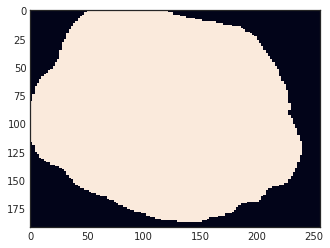

In [10]:
import matplotlib.pyplot as plt
demo = j[0,:,:,0]
plt.imshow(demo)

(8, 192, 256, 3)


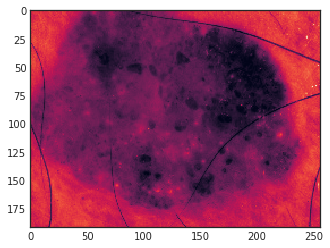

In [11]:
demo = i[0,:,:,0]
print(i.shape)
plt.imshow(demo)

In [7]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./keras.model",monitor='val_dice_coef', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [8]:
# https://github.com/titu1994/keras-normalized-optimizers
# Computes the L-2 norm of the gradient.
def l2_norm(grad):
    norm = K.sqrt(K.sum(K.square(grad))) + K.epsilon()
    return norm

class OptimizerWrapper(optimizers.Optimizer):

    def __init__(self, optimizer):     
        
        self.optimizer = optimizers.get(optimizer)

        # patch the `get_gradients` call
        self._optimizer_get_gradients = self.optimizer.get_gradients

    def get_gradients(self, loss, params):      
        grads = self._optimizer_get_gradients(loss, params)
        return grads

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        # monkey patch `get_gradients`
        self.optimizer.get_gradients = self.get_gradients

        # get the updates
        self.optimizer.get_updates(loss, params)

        # undo monkey patch
        self.optimizer.get_gradients = self._optimizer_get_gradients

        return self.updates

    def set_weights(self, weights):       
        self.optimizer.set_weights(weights)

    def get_weights(self):        
        return self.optimizer.get_weights()

    def get_config(self):       
        # properties of NormalizedOptimizer
        config = {'optimizer_name': self.optimizer.__class__.__name__.lower()}

        # optimizer config
        optimizer_config = {'optimizer_config': self.optimizer.get_config()}
        return dict(list(optimizer_config.items()) + list(config.items()))

    @property
    def weights(self):
        return self.optimizer.weights

    @property
    def updates(self):
        return self.optimizer.updates

    @classmethod
    def from_config(cls, config):
        raise NotImplementedError

    @classmethod
    def set_normalization_function(cls, name, func):
        global _NORMS
        _NORMS[name] = func

    @classmethod
    def get_normalization_functions(cls):        
        global _NORMS
        return sorted(list(_NORMS.keys()))


class NormalizedOptimizer(OptimizerWrapper):

    def __init__(self, optimizer, normalization='l2'):       
        super(NormalizedOptimizer, self).__init__(optimizer)

        if normalization not in _NORMS:
            raise ValueError('`normalization` must be one of %s.\n' 
                             'Provided was "%s".' % (str(sorted(list(_NORMS.keys()))), normalization))

        self.normalization = normalization
        self.normalization_fn = _NORMS[normalization]
        self.lr = K.variable(1e-3, name='lr')

    def get_gradients(self, loss, params):       
        grads = super(NormalizedOptimizer, self).get_gradients(loss, params)
        grads = [grad / self.normalization_fn(grad) for grad in grads]
        return grads

    def get_config(self):        
        # properties of NormalizedOptimizer
        config = {'normalization': self.normalization}

        # optimizer config
        base_config = super(NormalizedOptimizer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):       
        optimizer_config = {'class_name': config['optimizer_name'],
                            'config': config['optimizer_config']}

        optimizer = optimizers.get(optimizer_config)
        normalization = config['normalization']

        return cls(optimizer, normalization=normalization)


_NORMS = {
    'l2': l2_norm,
}

# register this optimizer to the global custom objects when it is imported
get_custom_objects().update({'NormalizedOptimizer': NormalizedOptimizer})

In [9]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def binary_focal_loss(y_true, y_pred):
    # # # filter out "ignore" anchors
    # anchor_state = K.max(y_true, axis=2)  # -1 for ignore, 0 for background, 1+ for objects
    # indices = tf.where(K.not_equal(anchor_state, -1))
    # y_true = tf.gather_nd(y_true, indices)
    # y_pred = tf.gather_nd(y_pred, indices)

    # compute the focal loss
    # CE(p_t) = -log(p_t)
    # FL(p_t) = -(1 - p_t) ** gamma * log(p_t)
    alpha_factor = K.ones_like(y_true) * alpha
    alpha_factor = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
    focal_weight = tf.where(K.equal(y_true, 1), 1 - y_pred, y_pred)
    focal_weight = alpha_factor * focal_weight ** gamma

    loss = focal_weight * K.binary_crossentropy(y_true, y_pred)
    return loss



In [11]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots,round_, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr
        self.round = round_

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./keras_{}.model".format(self.round),monitor='val_dice_coef', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [12]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath,last_file_path, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
        self.last_path = last_file_path
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  
#        self.model.save_weights(')        
        
    def on_train_end(self, logs=None):
        self.model.save_weights(self.last_path )        
        print('Saving Final Model Weights.......')
#        print(self.filepath.replace('swa','last'))
#        self.model.save_weights(self.last_path )
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')
        self.model.load_weights(self.last_path)

In [19]:
K.clear_session()
sgd = SGD(0.01, momentum=0.9, nesterov=True)
sgd = NormalizedOptimizer(sgd, normalization='l2')
model = UXception_all_separable(input_shape=(img_height,img_width,3))
model.summary()
model.compile(loss=bce_dice_loss, optimizer=sgd, metrics=[dice_coef,'acc'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 127, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 127, 32)  0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [20]:
epoch = 25
round_ = 6
model_name = 'SU-SWA-SCB'
batch_size= 16
swa = SWA('./swa_{}_{}_{}.model'.format(model_name,epoch,round_),'./last_{}_{}_{}.model'.format(model_name,epoch,round_),epoch-5)    
snapshot = SnapshotCallbackBuilder(nb_epochs=epoch,nb_snapshots=1,round_=round_,init_lr=1e-3)

history = model.fit_generator(train_generator,
                        steps_per_epoch=np.ceil(float(len(os.listdir(train_path))) / float(batch_size)),
                        epochs=epoch,
                        validation_data=val_generator, 
                        validation_steps=np.ceil(float(len(os.listdir(test_path))) / float(batch_size)),
                       # validation_steps=180//8,
                        callbacks=snapshot.get_callbacks(),verbose=1)


Stochastic weight averaging selected for last 5 epochs.
Epoch 1/25


InternalError: Blas SGEMM launch failed : m=93000, n=128, k=64
	 [[Node: block2_sepconv1/separable_conv2d = Conv2D[T=DT_FLOAT, _class=["loc:@train...kpropInput"], data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block2_sepconv1/separable_conv2d/depthwise, block2_sepconv1/pointwise_kernel/read)]]
	 [[Node: loss/mul/_2665 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_28790_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [32]:
for round_ in range(5):
    epochs = 5
    #swa = SWA('./keras_swa_ph2.model',95)
    #snapshot = SnapshotCallbackBuilder1(nb_epochs=epochs,nb_snapshots=5,init_lr=1e-3)
    snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,round_=round_,init_lr=1e-3)
    batch_size= 8



    history = model.fit_generator(train_generator,
                            steps_per_epoch=np.ceil(float(len(os.listdir(train_path))) / float(batch_size)),
                            epochs=epochs,
                            validation_data=val_generator, 
                            validation_steps=np.ceil(float(len(os.listdir(test_path))) / float(batch_size)),
                           # validation_steps=180//8,
                            callbacks=snapshot.get_callbacks(),verbose=2)

Stochastic weight averaging selected for last -15 epochs.
Epoch 1/5


InternalError: Blas SGEMM launch failed : m=93000, n=128, k=64
	 [[Node: block2_sepconv1/separable_conv2d = Conv2D[T=DT_FLOAT, _class=["loc:@train...kpropInput"], data_format="NHWC", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block2_sepconv1/separable_conv2d/depthwise, block2_sepconv1/pointwise_kernel/read)]]
	 [[Node: loss/mul/_3817 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_28790_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [22]:
epochs = 50
swa = SWA('./keras_2016_swa.model',45)
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,round_=0 ,init_lr=1e-3)
batch_size= 8



history = model.fit_generator(train_generator,
                        steps_per_epoch=np.ceil(float(len(os.listdir(train_path))) / float(batch_size)),
                        epochs=epochs,
                        validation_data=val_generator, 
                        #validation_steps=np.ceil(float(len(os.listdir(test_path))) / float(batch_size)),
                        validation_steps=np.ceil(float(180) / float(batch_size)),
                        callbacks=snapshot.get_callbacks(),verbose=2)

Stochastic weight averaging selected for last 5 epochs.
Epoch 1/50
 - 66s - loss: 0.3556 - dice_coef: 0.8850 - acc: 0.9202 - val_loss: 1.7995 - val_dice_coef: 0.7720 - val_acc: 0.7933

Epoch 00001: val_dice_coef improved from -inf to 0.77204, saving model to ./keras_0.model
Epoch 2/50
 - 52s - loss: 0.2510 - dice_coef: 0.9220 - acc: 0.9473 - val_loss: 1.0127 - val_dice_coef: 0.8602 - val_acc: 0.9021

Epoch 00002: val_dice_coef improved from 0.77204 to 0.86023, saving model to ./keras_0.model
Epoch 3/50
 - 52s - loss: 0.2155 - dice_coef: 0.9336 - acc: 0.9549 - val_loss: 0.2793 - val_dice_coef: 0.9343 - val_acc: 0.9500

Epoch 00003: val_dice_coef improved from 0.86023 to 0.93432, saving model to ./keras_0.model
Epoch 4/50
 - 52s - loss: 0.2043 - dice_coef: 0.9368 - acc: 0.9567 - val_loss: 0.3855 - val_dice_coef: 0.9226 - val_acc: 0.9427

Epoch 00004: val_dice_coef did not improve
Epoch 5/50
 - 52s - loss: 0.1990 - dice_coef: 0.9389 - acc: 0.9587 - val_loss: 0.1935 - val_dice_coef: 0.9412


Epoch 00046: val_dice_coef did not improve
Epoch 47/50
 - 52s - loss: 0.0966 - dice_coef: 0.9687 - acc: 0.9789 - val_loss: 0.2851 - val_dice_coef: 0.9393 - val_acc: 0.9546

Epoch 00047: val_dice_coef did not improve
Epoch 48/50
 - 52s - loss: 0.0992 - dice_coef: 0.9681 - acc: 0.9785 - val_loss: 0.1818 - val_dice_coef: 0.9524 - val_acc: 0.9625

Epoch 00048: val_dice_coef did not improve
Epoch 49/50
 - 52s - loss: 0.0959 - dice_coef: 0.9694 - acc: 0.9790 - val_loss: 0.2447 - val_dice_coef: 0.9447 - val_acc: 0.9557

Epoch 00049: val_dice_coef did not improve
Epoch 50/50
 - 52s - loss: 0.0929 - dice_coef: 0.9698 - acc: 0.9796 - val_loss: 0.2182 - val_dice_coef: 0.9369 - val_acc: 0.9507

Epoch 00050: val_dice_coef did not improve
Final model parameters set to stochastic weight average.
Final stochastic averaged weights saved to file.


In [13]:
import tensorflow as tf
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted)+1, tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [13]:
from __future__ import print_function
from __future__ import absolute_import
 
import warnings
import numpy as np
 
from keras.preprocessing import image
 
from keras.models import Model
from keras import layers
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import _obtain_input_shape


In [14]:
def UXception_all_separable(input_shape=(None, None, 3)):

    #backbone = MyselfXception(input_shape=input_shape,weights=None,include_top=False)
    backbone = Xception(input_shape=input_shape,weights=None,include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.1)(pool4)
    
     # Middle
    convm = SeparableConv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    # 10 -> 20
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.1)(uconv4)
    
    uconv4 = SeparableConv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1,name='output_4')(uconv4)
    
    # 10 -> 20
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(0.1)(uconv3)
    
    uconv3 = SeparableConv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1,name='output_3')(uconv3)

    # 20 -> 40
    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1,name='output_2')(uconv2)
    
    # 40 -> 80
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = SeparableConv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1,name='output_1')(uconv1)
    
    
    # 80 -> 160
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = SeparableConv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1,name='output_0')(uconv0)
    
    uconv0 = Dropout(0.1/2)(uconv0)
    output_layer = Conv2D(1, (1,1),activation=None,padding='same')(uconv0)    
    output_layer_sigmoid = Activation('sigmoid',name='prediction')(output_layer)
    
    model = Model(input, output_layer_sigmoid)
    model.name = 'u-xception'

    return model

In [18]:
from keras.layers import SeparableConv2D
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = SeparableConv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [19]:
def UXception_all_conv(input_shape=(None, None, 3)):

    backbone = MyselfXception(input_shape=input_shape,weights=None,include_top=False)
    #backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.1)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    # 10 -> 20
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.1)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1,name='output_4')(uconv4)
    
    # 10 -> 20
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(0.1)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1,name='output_3')(uconv3)

    # 20 -> 40
    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1,name='output_2')(uconv2)
    
    # 40 -> 80
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1,name='output_1')(uconv1)
    
    
    # 80 -> 160
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1,name='output_0')(uconv0)
    
    uconv0 = Dropout(0.1/2)(uconv0)
    output_layer = Conv2D(1, (1,1),activation=None,padding='same')(uconv0)    
    output_layer_sigmoid = Activation('sigmoid',name='prediction')(output_layer)
    
    model = Model(input, output_layer_sigmoid)
    model.name = 'u-xception'

    return model

In [20]:
def UXception_all_separable(input_shape=(None, None, 3)):

    #backbone = MyselfXception(input_shape=input_shape,weights=None,include_top=False)
    backbone = Xception(input_shape=input_shape,weights=None,include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.1)(pool4)
    
     # Middle
    convm = SeparableConv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    # 10 -> 20
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.1)(uconv4)
    
    uconv4 = SeparableConv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1,name='output_4')(uconv4)
    
    # 10 -> 20
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(0.1)(uconv3)
    
    uconv3 = SeparableConv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1,name='output_3')(uconv3)

    # 20 -> 40
    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1,name='output_2')(uconv2)
    
    # 40 -> 80
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = SeparableConv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1,name='output_1')(uconv1)
    
    
    # 80 -> 160
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = SeparableConv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1,name='output_0')(uconv0)
    
    uconv0 = Dropout(0.1/2)(uconv0)
    output_layer = Conv2D(1, (1,1),activation=None,padding='same')(uconv0)    
    output_layer_sigmoid = Activation('sigmoid',name='prediction')(output_layer)
    
    model = Model(input, output_layer_sigmoid)
    model.name = 'u-xception'

    return model

In [30]:

K.clear_session()
model = UXception_all_separable(input_shape=(img_height,img_width,3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 127, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 127, 32)  0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

block9_sepconv1 (SeparableConv2 (None, 12, 16, 728)  536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 12, 16, 728)  2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 12, 16, 728)  0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 12, 16, 728)  536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 12, 16, 728)  2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 12, 16, 256)  1024        separable_conv2d_6[0][0]         
__________________________________________________________________________________________________
add_15 (Add)                    (None, 12, 16, 256)  0           batch_normalization_16[0][0]     
                                                                 batch_normalization_14[0][0]     
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 12, 16, 256)  0           add_15[0][0]                     
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 12, 16, 256)  1024        leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
separable_

__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, 96, 128, 32)  0           batch_normalization_43[0][0]     
__________________________________________________________________________________________________
separable_conv2d_25 (SeparableC (None, 96, 128, 32)  1344        leaky_re_lu_22[0][0]             
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 96, 128, 32)  128         separable_conv2d_25[0][0]        
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 96, 128, 32)  128         add_21[0][0]                     
__________________________________________________________________________________________________
add_22 (Add)                    (None, 96, 128, 32)  0           batch_normalization_44[0][0]     
          

In [20]:
model.compile(loss=bce_dice_loss, optimizer=sgd, metrics=[dice_coef,'acc'])

NameError: name 'sgd' is not defined

In [9]:
model = get_unet()
model.summary()

NameError: name 'get_unet' is not defined

In [31]:
input_x = model.layers[0].input
output_layer = model.layers[-1].input
model_lovasz = Model(input_x, output_layer)

In [16]:
from tqdm import tqdm
test_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/seg_test/'
test_img_list = []
for name in tqdm(os.listdir(test_path)):
    img = cv2.resize(cv2.imread(os.path.join(test_path,name))[:,:,0],(img_width,img_height))
    #prediction = model.predict(img)
    test_img_list.append(np.expand_dims(img,axis=-1))
test_img_array = np.array(test_img_list,np.float32)/255

100%|████████████████████████████████████████████████████████████████████████████████| 379/379 [00:27<00:00, 13.67it/s]


In [25]:
import time
start = time.time()
import gc
import os 
from tqdm import tqdm
#model.load_weights('./keras_2016_swa.model')
model.load_weights('./keras_2016_swa.modell')
#test_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/polar_test/'
test_path = 'C:/Users/hyc/Desktop/skin_lesion/segmentation/seg_test/'
prediction_path ='./prediction_2016_s/'
if not os.path.exists(prediction_path):
    os.mkdir(prediction_path)
test_img_list = []
for name in tqdm(os.listdir(test_path)):
    #img = cv2.resize(cv2.imread(os.path.join(test_path,name))[:,:,0],(img_width,img_height))/255
    img = cv2.resize(cv2.imread(os.path.join(test_path,name)),(img_width,img_height))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)/255
    #print(img)
    #print(img.shape)
    img = np.expand_dims(img,axis=0)
    #img = np.expand_dims(img,axis=-1)
    pred = model.predict(img)
    pred = pred[0,:,:,0]*255
    cv2.imwrite(prediction_path+name,pred)
    
end = time.time()
print("total_test_time: {}".format(end-start))

100%|████████████████████████████████████████████████████████████████████████████████| 379/379 [00:13<00:00, 27.95it/s]


total_test_time: 13.934715270996094


In [115]:
import time
start = time.time()
import gc
import os 
from tqdm import tqdm
model.load_weights('keras.model')
test_path = './ph2/img/'
prediction_path ='./ph2/prediction_validataion_swa_speconv/'
if not os.path.exists(prediction_path):
    os.mkdir(prediction_path)
test_img_list = []
for name in tqdm(os.listdir(test_path)[160:]):
    #img = cv2.resize(cv2.imread(os.path.join(test_path,name))[:,:,0],(img_width,img_height))/255
    img = cv2.resize(cv2.imread(os.path.join(test_path,name)),(img_width,img_height))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)/255
    #print(img)
    #print(img.shape)
    img = np.expand_dims(img,axis=0)
    #img = np.expand_dims(img,axis=-1)
    pred = model.predict(img)
    pred = pred[0,:,:,0]*255
    cv2.imwrite(prediction_path+name,pred)
    
end = time.time()
print("total_test_time: {}".format(end-start))

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.43it/s]


total_test_time: 9.633894443511963


In [25]:
import time
start = time.time()
import gc
import os 
from tqdm import tqdm
model.load_weights('keras_ph2_swa.model')
test_path = 'C:/Users/hyc/Desktop/skin_lesion/2017/2017/test_gt/'
prediction_path ='C:/Users/hyc/Desktop/skin_lesion/2017/prediction/'
if not os.path.exists(prediction_path):
    os.mkdir(prediction_path)
test_img_list = []
for name in tqdm(os.listdir(test_path)):
    #img = cv2.resize(cv2.imread(os.path.join(test_path,name))[:,:,0],(img_width,img_height))/255
    img = cv2.resize(cv2.imread(os.path.join(test_path,name)),(img_width,img_height))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)/255
    #print(img)
    #print(img.shape)
    img = np.expand_dims(img,axis=0)
    #img = np.expand_dims(img,axis=-1)
    pred = model.predict(img)
    pred = 255-pred[0,:,:,0]*255
    cv2.imwrite(prediction_path+name,pred)
    
end = time.time()
print("total_test_time: {}".format(end-start))




  0%|                                                                                          | 0/600 [00:00<?, ?it/s]


  0%|▏                                                                                 | 1/600 [00:00<01:07,  8.84it/s]


  0%|▎                                                                                 | 2/600 [00:00<01:07,  8.86it/s]


  1%|▌                                                                                 | 4/600 [00:00<00:54, 10.94it/s]


  1%|▊                                                                                 | 6/600 [00:00<00:50, 11.79it/s]


  1%|█                                                                                 | 8/600 [00:00<00:47, 12.37it/s]


  2%|█▎                                                                               | 10/600 [00:00<00:47, 12.41it/s]


  2%|█▌                                                                               | 12/600 [00:00<00:46, 12.56it/s]


  2%|█▉              

 34%|███████████████████████████▌                                                    | 207/600 [00:19<00:37, 10.47it/s]


 35%|███████████████████████████▊                                                    | 209/600 [00:19<00:37, 10.50it/s]


 35%|████████████████████████████▏                                                   | 211/600 [00:20<00:36, 10.53it/s]


 36%|████████████████████████████▍                                                   | 213/600 [00:20<00:36, 10.50it/s]


 36%|████████████████████████████▋                                                   | 215/600 [00:20<00:36, 10.46it/s]


 36%|████████████████████████████▉                                                   | 217/600 [00:20<00:36, 10.49it/s]


 36%|█████████████████████████████▏                                                  | 219/600 [00:20<00:36, 10.52it/s]

KeyboardInterrupt: 




 36%|█████████████████████████████▏                                                  | 219/600 [00:33<00:57,  6.59it/s]

In [22]:
import time
import gc
import os 
from tqdm import tqdm
start = time.time()
model.load_weights('./keras.model')
test_path = './seg_test/'
prediction_path ='./predictio_B/'
if not os.path.exists(prediction_path):
    os.mkdir(prediction_path)
test_img_list = []
for name in tqdm(os.listdir(test_path)):
    orig = cv2.imread(os.path.join(test_path,name))
    img = cv2.resize(orig,(img_width,img_height))/255
    #print(img)
    #print(img.shape)
    img = np.expand_dims(img,axis=0)
    #img = np.expand_dims(img,axis=-1)
    pred = model.predict(img)
    pred = (pred[0,:,:,0]>0.5)*255
    try:

        label_img = label(pred)
        regions = regionprops(label_img)
        area_list = []
        for region in regions:
            area_list.append(region.area)
        
        index_max = np.argmax(area_list)
        pred[label_img!=index_max+1]=0
    except:
        pass
    #pred = cv2.cvtColor(pred,cv2.COLOR_GRAY2BGR)
    #print(pred.shape)
    #pred = cv2.resize(pred,orig.shape[:2])
    cv2.imwrite(prediction_path+name,pred)
    
end = time.time()
print('total_testing_time:{}'.format(end-start))

100%|████████████████████████████████████████████████████████████████████████████████| 379/379 [00:19<00:00, 19.20it/s]


total_testing_time:19.85120916366577


In [50]:
model_lovasz.load_weights('unet.hdf5')
x = model_lovasz.output
x = Activation('sigmoid')(x)
model_lovasz_sigmoid = Model(model_lovasz.input,x)
model_lovasz_sigmoid.summary()


NameError: name 'model_lovasz' is not defined

In [116]:
print(prediction.shape)

(900, 256, 256, 1)


In [117]:
prediction_path ='./prediction/'
if not os.path.exists(prediction_path):
    os.mkdir(prediction_path)

name_list = os.listdir(test_path)
for i in range(prediction.shape[0]):
    
    pred = prediction[i,:,:]
   # print(np.sum(pred))
    cv2.imwrite(prediction_path+name_list[i],pred*255)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [35]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import Model, load_model
import keras.applications.resnet50 as resnet
from keras.layers import UpSampling2D, Conv2D


# Please set an appropriate image file
INPUT_IMG_FILE = "./ISIC_0012207.jpg"

################################################################
# The following parameters can be changed to other models
# that use global average pooling.
# e.g.) InceptionResnetV2 / NASNetLarge
NETWORK_INPUT_SIZE = (256,192)
#MODEL_CLASS = resnet.ResNet50
PREPROCESS_FN = resnet.preprocess_input
LAST_CONV_LAYER_0 = "output_0"
LAST_CONV_LAYER_1 = "output_1"
LAST_CONV_LAYER_2 = "output_2"
LAST_CONV_LAYER_3 = "output_3"
LAST_CONV_LAYER_4 = "output_4"
PRED_LAYER = "prediction"

K.clear_session()
model = UXception_all_separable(input_shape=(img_height,img_width,3))
#model = load_model('./weights/2017/keras_dice_coef_0_conv.model')
model.summary()
model.load_weights('./weights/2017/keras_2017_all_speravle.model')
#model.summary()    

last_conv_output_0 = model.get_layer(LAST_CONV_LAYER_0).output
last_conv_output_1 = model.get_layer(LAST_CONV_LAYER_1).output
last_conv_output_2 = model.get_layer(LAST_CONV_LAYER_2).output
last_conv_output_3 = model.get_layer(LAST_CONV_LAYER_3).output
last_conv_output_4 = model.get_layer(LAST_CONV_LAYER_4).output


x0 = UpSampling2D(size=(1, 1))(
    last_conv_output_0)
x1 = UpSampling2D(size=(2, 2))(
    last_conv_output_1)
x2 = UpSampling2D(size=(4, 4))(
    last_conv_output_2)
x3 = UpSampling2D(size=(8, 8))(
    last_conv_output_3)
x4 = UpSampling2D(size=(16, 16))(
    last_conv_output_4)

x0 = Conv2D(filters=1, kernel_size=(
    1, 1),activation='sigmoid', name="predictions_2")(x0)
x1 = Conv2D(filters=1, kernel_size=(
    1, 1),activation='sigmoid', name="predictions_2")(x1)
x2 = Conv2D(filters=1, kernel_size=(
    1, 1),activation='sigmoid', name="predictions_2")(x2)
x3 = Conv2D(filters=1, kernel_size=(
    1, 1),activation='sigmoid', name="predictions_2")(x3)
x4 = Conv2D(filters=1, kernel_size=(
    1, 1),activation='sigmoid', name="predictions_2")(x4)


model_0 = Model(inputs=model.input,
                  outputs=x0)
model_1 = Model(inputs=model.input,
                  outputs=x1) 
model_2 = Model(inputs=model.input,
                  outputs=x2) 
model_3 = Model(inputs=model.input,
                  outputs=x3)                                          
model_4 = Model(inputs=model.input,
                  outputs=x4)

img_path = 'C:/Users/hyc/Desktop/skin_lesion/2017/2017/test_img_resized/'
import os
from tqdm import tqdm
def make_dir_if_not(path):
    if not os.path.exists(path):
        os.mkdir(path)
for name in tqdm(os.listdir(img_path)):
    for num in range(5):
        path = './gray_cam_output_{}/'.format(num)
        make_dir_if_not(path)
    original_img = cv2.imread(img_path+name)/255   
    #img = cv2.resize(original_img, NETWORK_INPUT_SIZE)/255
    imgs = np.expand_dims(original_img, axis=0)
    #for name in
    preds_0 = model_0.predict(imgs)[0,:,:,0]
    preds_1 = model_1.predict(imgs)[0,:,:,0]
    preds_2 = model_2.predict(imgs)[0,:,:,0]
    preds_3 = model_3.predict(imgs)[0,:,:,0]
    preds_4 = model_4.predict(imgs)[0,:,:,0]

    preds_0 = preds_0/np.max(preds_0)
   # print(np.max(preds_0))
    preds_1 = preds_1/np.max(preds_1)
    preds_2 = preds_2/np.max(preds_2)
    preds_3 = preds_3/np.max(preds_3)
    preds_4 = preds_4/np.max(preds_4)
    #preds_0 = cv2.applyColorMap(preds_0, cv2.COLORMAP_JET)
    
    name_0 = name.replace('.jpg','output_0.jpg')
    name_1 = name.replace('.jpg','output_1.jpg')
    name_2 = name.replace('.jpg','output_2.jpg')
    name_3 = name.replace('.jpg','output_3.jpg')
    name_4 = name.replace('.jpg','output_4.jpg')
    
    
    
    cv2.imwrite('./gray_cam_output_{}/'.format(0)+name_0,preds_0*255)
    cv2.imwrite('./gray_cam_output_{}/'.format(1)+name_1,preds_1*255)
    cv2.imwrite('./gray_cam_output_{}/'.format(2)+name_2,preds_2*255)
    cv2.imwrite('./gray_cam_output_{}/'.format(3)+name_3,preds_3*255)
    cv2.imwrite('./gray_cam_output_{}/'.format(4)+name_4,preds_4*255)

    for num in range(5):
        path = './color_cam_output_{}/'.format(num)
        make_dir_if_not(path)
    gray_0 = cv2.imread('./gray_cam_output_{}/'.format(0)+name_0)       
    gray_1 = cv2.imread('./gray_cam_output_{}/'.format(1)+name_1)
    gray_2 = cv2.imread('./gray_cam_output_{}/'.format(2)+name_2)
    gray_3 = cv2.imread('./gray_cam_output_{}/'.format(3)+name_3)
    gray_4 = cv2.imread('./gray_cam_output_{}/'.format(4)+name_4)

    color_0 = cv2.applyColorMap(gray_0, cv2.COLORMAP_JET)    
    color_1 = cv2.applyColorMap(gray_1, cv2.COLORMAP_JET)   
    color_2 = cv2.applyColorMap(gray_2, cv2.COLORMAP_JET)   
    color_3 = cv2.applyColorMap(gray_3, cv2.COLORMAP_JET)   
    color_4 = cv2.applyColorMap(gray_4, cv2.COLORMAP_JET)
  
    cv2.imwrite('./color_cam_output_{}/'.format(0)+name_0,color_0)    
    cv2.imwrite('./color_cam_output_{}/'.format(1)+name_1,color_1)
    cv2.imwrite('./color_cam_output_{}/'.format(2)+name_2,color_2)
    cv2.imwrite('./color_cam_output_{}/'.format(3)+name_3,color_3)
    cv2.imwrite('./color_cam_output_{}/'.format(4)+name_4,color_4)  

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 127, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 127, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 127, 32)  0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

block9_sepconv1 (SeparableConv2 (None, 12, 16, 728)  536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 12, 16, 728)  2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 12, 16, 728)  0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 12, 16, 728)  536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 12, 16, 728)  2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 12, 16, 256)  1024        separable_conv2d_6[0][0]         
__________________________________________________________________________________________________
add_15 (Add)                    (None, 12, 16, 256)  0           batch_normalization_16[0][0]     
                                                                 batch_normalization_14[0][0]     
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 12, 16, 256)  0           add_15[0][0]                     
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 12, 16, 256)  1024        leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
separable_

__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, 96, 128, 32)  0           batch_normalization_43[0][0]     
__________________________________________________________________________________________________
separable_conv2d_24 (SeparableC (None, 96, 128, 32)  1344        leaky_re_lu_22[0][0]             
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 96, 128, 32)  128         separable_conv2d_24[0][0]        
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 96, 128, 32)  128         add_21[0][0]                     
__________________________________________________________________________________________________
add_22 (Add)                    (None, 96, 128, 32)  0           batch_normalization_44[0][0]     
          



  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

  0%|▏                                                                                 | 1/600 [00:03<30:17,  3.03s/it]

  0%|▎                                                                                 | 2/600 [00:03<15:53,  1.59s/it]

  0%|▍                                                                                 | 3/600 [00:03<11:08,  1.12s/it]

  1%|▌                                                                                 | 4/600 [00:03<08:43,  1.14it/s]

  1%|▋                                                                                 | 5/600 [00:03<07:15,  1.37it/s]

  1%|▊                                                                                 | 6/600 [00:03<06:16,  1.58it/s]

  1%|▉                                                                                 | 7/600 [00:03<05:34,  1.77it/s]

  1%|█                        

 22%|█████████████████▊                                                              | 134/600 [00:24<01:25,  5.46it/s]

 22%|██████████████████                                                              | 135/600 [00:24<01:25,  5.47it/s]

 23%|██████████████████▏                                                             | 136/600 [00:24<01:24,  5.47it/s]

 23%|██████████████████▎                                                             | 137/600 [00:25<01:24,  5.47it/s]

 23%|██████████████████▍                                                             | 138/600 [00:25<01:24,  5.48it/s]

 23%|██████████████████▌                                                             | 139/600 [00:25<01:25,  5.40it/s]

 23%|██████████████████▋                                                             | 140/600 [00:25<01:25,  5.41it/s]

 24%|██████████████████▊                                                             | 141/600 [00:26<01:24,  5.41it/s]

 24%|██████████████████▉        

 45%|███████████████████████████████████▋                                            | 268/600 [00:48<01:00,  5.51it/s]

 45%|███████████████████████████████████▊                                            | 269/600 [00:48<01:00,  5.52it/s]

 45%|████████████████████████████████████                                            | 270/600 [00:48<00:59,  5.52it/s]

 45%|████████████████████████████████████▏                                           | 271/600 [00:49<00:59,  5.52it/s]

 45%|████████████████████████████████████▎                                           | 272/600 [00:49<00:59,  5.53it/s]

 46%|████████████████████████████████████▍                                           | 273/600 [00:49<00:59,  5.53it/s]

 46%|████████████████████████████████████▌                                           | 274/600 [00:49<00:58,  5.53it/s]

 46%|████████████████████████████████████▋                                           | 275/600 [00:49<00:58,  5.53it/s]

 46%|███████████████████████████

 67%|█████████████████████████████████████████████████████▌                          | 402/600 [01:11<00:35,  5.61it/s]

 67%|█████████████████████████████████████████████████████▋                          | 403/600 [01:11<00:35,  5.61it/s]

 67%|█████████████████████████████████████████████████████▊                          | 404/600 [01:11<00:34,  5.61it/s]

 68%|██████████████████████████████████████████████████████                          | 405/600 [01:12<00:34,  5.61it/s]

 68%|██████████████████████████████████████████████████████▏                         | 406/600 [01:12<00:34,  5.62it/s]

 68%|██████████████████████████████████████████████████████▎                         | 407/600 [01:12<00:34,  5.62it/s]

 68%|██████████████████████████████████████████████████████▍                         | 408/600 [01:12<00:34,  5.62it/s]

 68%|██████████████████████████████████████████████████████▌                         | 409/600 [01:12<00:33,  5.62it/s]

 68%|███████████████████████████

 89%|███████████████████████████████████████████████████████████████████████▍        | 536/600 [01:34<00:11,  5.65it/s]

 90%|███████████████████████████████████████████████████████████████████████▌        | 537/600 [01:34<00:11,  5.65it/s]

 90%|███████████████████████████████████████████████████████████████████████▋        | 538/600 [01:35<00:10,  5.66it/s]

 90%|███████████████████████████████████████████████████████████████████████▊        | 539/600 [01:35<00:10,  5.66it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 540/600 [01:35<00:10,  5.66it/s]

 90%|████████████████████████████████████████████████████████████████████████▏       | 541/600 [01:35<00:10,  5.65it/s]

 90%|████████████████████████████████████████████████████████████████████████▎       | 542/600 [01:35<00:10,  5.65it/s]

 90%|████████████████████████████████████████████████████████████████████████▍       | 543/600 [01:36<00:10,  5.65it/s]

 91%|███████████████████████████

In [1]:
import cv2
img = cv2.imread('./output_1.jpg')
print(img.shape)
preds_0 = cv2.applyColorMap(img, cv2.COLORMAP_JET)
cv2.imwrite('./output_1_color.jpg',preds_0)

(192, 256, 3)


True

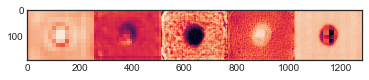

In [70]:
plt.figure(figsize=(6, 6.5))
plt.imshow(np.concatenate([preds_4,preds_3,preds_2,preds_1,preds_0],axis=-1))
plt.savefig('output.jpg')

(1, 192, 256, 1)


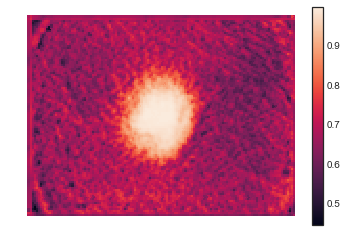

In [61]:
#model.load_weights('./weights/2017/keras_2017_all_speravle.model')
preds = cam_model.predict(imgs)
print(preds.shape)
preds =  preds[0,:,:,0]
#preds = np.stack([preds[0,:,:,0]*255,preds[0,:,:,0]*255,preds[0,:,:,0]*255],axis=-1)
plt.close()
plt.figure(2)
plt.pcolor(preds)
plt.colorbar()
cv2.imwrite('output_1.jpg',preds*255)
# 4. post processing
plt.axis('off')
plt.imshow(preds)
plt.savefig('output_2.jpg')

In [3]:

cv2.imwrite('cam.jpg',class_activation_map)

True